# **Neural network to model the lateral vehicle dynamics**

This tutorial implements the model-structured neural network in Fig. 3 of the paper titled:

*A Mental Simulation Approach for Learning Neural-Network Predictive Control (in Self-Driving Cars)*

(available at https://ieeexplore.ieee.org/document/9234399)

This NN models the pure lateral dynamics of an urban car.


## Initialization

### Import packages

In [62]:
import sys
import os
import torch
import pandas as pd
import scipy as sp
import numpy as np
from nnodely.initializer import *
from nnodely.utils import *

print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))
from nnodely import *
from nnodely import relation
from nnodely import earlystopping
relation.NeuObj_names = []  # reset the list of NeuObj names

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()


Current working directory:  /Users/mattiapiccinini/Documents/research/nnodely/nnodely-applications/vehicle/model_lateral_vehicle_dynamics


### Configurations and known constant parameters

In [63]:
# Path to the data folder
data_folder = os.path.join(os.getcwd(),'dataset')

# Import the file with the vehicle data
vehicle_data_csv = os.path.join(data_folder,'other_data','vehicle_data.csv')

# Import the file with the steering maps
steer_maps_file = os.path.join(data_folder,'other_data','steer_map.txt')
steer_map_load  = np.loadtxt(steer_maps_file, delimiter='\t', skiprows=1)
delta_w_avg_map_values = np.float64(np.deg2rad(steer_map_load[:,0]))
delta_w_avg_map_values = delta_w_avg_map_values[:,np.newaxis].tolist()  # add a dimension
delta_sw_map_values = np.float64(np.deg2rad(steer_map_load[:,1]))
delta_sw_map_values = delta_sw_map_values[:,np.newaxis].tolist()  # add a dimension

## NN model

### Custom parametric functions

### Internal architecture

In [64]:
relation.NeuObj_names = []  # reset the list of NeuObj names

# -----------------------------------------------
# Neural model inputs and outputs
# -----------------------------------------------
curv  = Input('curv')          # [1/m] path curvature
vx    = Input('vx')            # [m/s] longitudinal velocity  
steer = Input('steer')         # [rad] steering wheel angle 

# Load the training and validation data
data_folder_train = os.path.join(data_folder,'training')
data_folder_valid = os.path.join(data_folder,'validation')

# Extract the max values of vx from the training set
min_vx_train = min(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['u'].values)
max_vx_train = max(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['u'].values)

# -----------------------------------------------
# Hyperparameters
# -----------------------------------------------
# Window size for the inputs
num_samples_past_steer = 15   # number of samples in the past for the steering wheel angle prediction

# Sample time for the input window (in seconds)
sample_time = 0.05   # this can be different from the sample time of the dataset (an internal interpolation is performed)

# Number of local models (aka channels) to model the lateral dynamics in different ranges of forward speed vx
num_channels_vx = 3
chan_centers_vx = list(np.linspace(min_vx_train, max_vx_train, num=num_channels_vx))  # centers of the channels

# -----------------------------------------------
# Local models to capture the pure lateral transient vehicle dynamics
# in different ranges of forward speed vx
# -----------------------------------------------
# Activation functions for the local models
activ_fcns_vx = Fuzzify(centers=chan_centers_vx, functions='Triangular')(vx.last())

# Define the local models
local_model_lat_dyna = LocalModel(input_function=lambda: Fir(parameter_init = init_exp, 
                                  parameter_init_params={'size_index':0, 'max_value':0.1, 
                                                         'lambda':5, 'monotonicity':'increasing'}))
out_local_model_lat_dyna = local_model_lat_dyna(steer.sw(num_samples_past_steer), activ_fcns_vx)

# -----------------------------------------------
# Understeering gradient correction
# -----------------------------------------------
# Custom function to model the understeering gradient correction
def understeer_corr(input,vx,  # inputs
                    A          # learnable parameter
                    ):
  return input * (1 / (1 + A * torch.pow(vx,2)))

A_guess = Parameter('A',values=[[1e-4]])  # initial guess for the understeering gradient learnable parameter

# Parametric function to model the understeering gradient correction
out_understeer_corr = ParamFun(understeer_corr,
                               constants=[],          # constant parameters
                               parameters=[A_guess]   # learnable parameters
                               )(out_local_model_lat_dyna, vx.last())

# Model output: trajectory curvature at the current time step
curv_out = Output('curvature', out_understeer_corr)  # output of the model 


### nnodely definitions

In [65]:
# Create a nnodely model
path_folder = os.path.join(os.getcwd(),'trained_models')    # folder to save the model
lat_dyna_model = nnodely(visualizer='Standard',seed=12,workspace=path_folder,save_history=False)  #MPLVisualizer()

# Add the neural model to the nnodely structure
lat_dyna_model.addModel('curv',[curv_out])

# Add a loss function: mean squared error for the curvature prediction
lat_dyna_model.addMinimize('curv_error', 
                           curv.next(),  # next means the first value in the "future"
                           curv_out, 
                           loss_function='mse')


#### Create the model

In [66]:
lat_dyna_model.neuralizeModel(sample_time)  # neuralize the model with the chosen sample time

================================ nnodely Model =================================
{'Constants': {},
 'Functions': {'FFuzzify106': {'centers': [9.574318117487577,
                                           49.95740934812816,
                                           90.34050057876874],
                               'dim_out': {'dim': 3},
                               'functions': 'Triangular',
                               'names': 'Triangular'},
               'FParamFun112': {'code': 'def understeer_corr(input,vx,  # '
                                        'inputs\n'
                                        '                    A          # '
                                        'learnable parameter\n'
                                        '                    ):\n'
                                        '  return input * (1 / (1 + A * '
                                        'torch.pow(vx,2)))\n',
                                'in_dim': [{'dim': 1, 'sw': 1},
            

## Training and validation datasets

In [67]:
# Pass the training and the validation datasets to the nnodely structure
data_struct = ['','steer','curv','vx']  
lat_dyna_model.loadData(name='training_set', source=data_folder_train, format=data_struct, skiplines=1)
lat_dyna_model.loadData(name='validation_set', source=data_folder_valid, format=data_struct, skiplines=1)


============================ nnodely Model Dataset =============================
Dataset Name:                 training_set
Number of files:              1
Total number of samples:      5599
Shape of vx:                  (5599, 1, 1)
Shape of steer:               (5599, 15, 1)
Shape of curv:                (5599, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 validation_set
Number of files:              1
Total number of samples:      4580
Shape of vx:                  (4580, 1, 1)
Shape of steer:               (4580, 15, 1)
Shape of curv:                (4580, 1, 1)


## Training

### Train the feed-forward NN (no auto-regression) in open-loop 

In [68]:
num_epochs = 6000
batch_size = 200
learn_rate = 1e-3  # learning rate
early_stop_patience = 100  # n. of epochs without improvement to stop the training
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate}

flag_train_now = 1  # flag to train the model now or load a pre-trained model
if flag_train_now:
  train_result_open_loop = lat_dyna_model.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                                     training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                     early_stopping=earlystopping.early_stop_patience,  
                                                     early_stopping_params={'patience':early_stop_patience,
                                                                            'error':'curv_error'})  
else:
  # Load the trained model
  lat_dyna_model.loadModel() 

======================== nnodely Model Train Parameters ========================
models:                       ['curv']
num of epochs:                6000
update per epochs:            27.995
└>(n_samples-batch_size)/batch_size+1
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'curv_error', 'patience': 100}
train dataset:                training_set
	- num of samples:            5599
	- batch size:                200
	- unused samples:            0.0
	  └>n_samples-update_per_epochs*batch_size
val dataset:                  validation_set
val {batch size, samples}:    {200, 4580}
minimizers:                   {'curv_error': {'A': 'SamplePart277',
                                              'B': 'curvature',
                                              'loss': 'mse'}}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.001}
optimizer params:             [{'params': 'A'},
                

In [69]:
# Print the trained NN parameters
lat_dyna_model.neuralizeModel()

if flag_train_now:
  # Save the trained model
  lat_dyna_model.saveModel()

================================ nnodely Model =================================
{'Constants': {},
 'Functions': {'FFuzzify106': {'centers': [9.574318117487577,
                                           49.95740934812816,
                                           90.34050057876874],
                               'dim_out': {'dim': 3},
                               'functions': 'Triangular',
                               'names': 'Triangular'},
               'FParamFun112': {'code': 'def understeer_corr(input,vx,  # '
                                        'inputs\n'
                                        '                    A          # '
                                        'learnable parameter\n'
                                        '                    ):\n'
                                        '  return input * (1 / (1 + A * '
                                        'torch.pow(vx,2)))\n',
                                'in_dim': [{'dim': 1, 'sw': 1},
            

#### Test on a new dataset

MSE on the test set:  [9.13996175e-07]  1/m


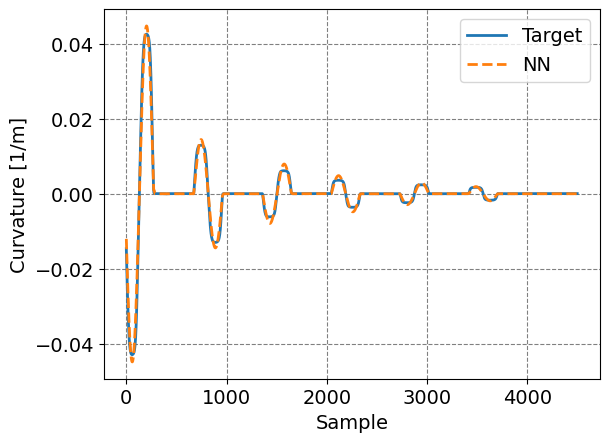

In [70]:
# Test on a new dataset
num_samples_use  = 4500
samples_test_set = lat_dyna_model.getSamples('validation_set', index=0, window=num_samples_use) 
out_nn_test_set  = lat_dyna_model(samples_test_set, sampled=True)
out_nn_test_set_extract = np.asarray(out_nn_test_set['curvature'])

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['curv']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['curv'][i]

# Compute the MSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
mse_calc = mse_calc/len(samples_test_set_extract)
print('MSE on the test set: ', mse_calc, ' 1/m')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(samples_test_set_extract,label='Target',linewidth=2)
  plt.plot(out_nn_test_set_extract,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Curvature [1/m]')
  plt.legend()
  plt.grid()
  plt.show()

# Test with custom data
#lat_dyna_model({'curv':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'steer':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]})